In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import h5py
import json
import os
from bmtool.util.util import load_nodes_from_paths

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
from build_input import get_populations, t_start, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "short_rand"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

pop_color = plot.pop_color
pop_names = plot.pop_names

### Load data

In [2]:
stim_type, paths, stim_info, config_hp = utils.get_trial_info(TRIAL_PATH)
stimulus_type, isbaseline, isstandard = stim_type
INPUT_PATH, NODE_FILES, SPIKE_FILE = paths
t_stop, stim_setting, stim_params = stim_info

if isbaseline:
    windows = np.array([[t_start, t_stop]])
else:
    t_start = stim_params['t_start']
    windows = process.get_stim_windows(stim_params['on_time'], stim_params['off_time'],
                                       t_start, t_stop)

In [3]:
network_name = 'cortex'

node_df = load_nodes_from_paths(NODE_FILES)[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spikes_df = utils.load_spikes_to_df(SPIKE_FILE, network_name)

### Spike Raster

#### Sort cell IDs

In [4]:
if isbaseline:
#     group_ids = [node_df.sort_values('pos_z').index]  # mix populations
    group_ids = [node_df.loc[grp].sort_values('pos_z').index for grp in pop_ids.values()]  # separate populations
else:
    _, group_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
    group_ids.append(sorted(set(node_df.index) - set(np.concatenate(group_ids))))

z_5A = 0.  # boundary between 5A and 5B
sorted_groups = [[], []] # differentiate 5B and 5A
for grp in group_ids:
    grp = np.asarray(grp)
    idx_5A = node_df.loc[grp, 'pos_z'] >= z_5A
    sorted_groups[0].append(grp[~idx_5A])
    sorted_groups[1].append(grp[idx_5A])

sorted_ids = pd.Series(-1, index=node_df.index)
for i, node_id in enumerate(np.concatenate(sum(sorted_groups, []))):
    sorted_ids[node_id] = i

node_df['sorted_id'] = sorted_ids
spikes_df['sorted_id'] = node_df.loc[spikes_df['node_ids'], 'sorted_id'].values

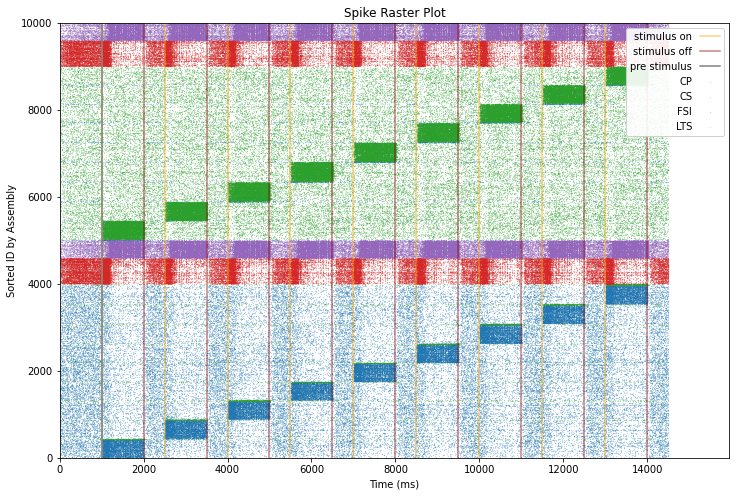

In [5]:
# %matplotlib notebook

spikes_df['pop_name'] = node_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, id_column='sorted_id', s=0.01, ax=ax)
if isbaseline:
    ax.set_ylabel('Sorted ID by Depth')
else:
    for i, win in enumerate(windows):
        labels = [None, None] if i else ['stimulus on', 'stimulus off']
        ax.axvline(win[0] * 1000, color='orange', alpha=0.5, label=labels[0])
        ax.axvline(win[1] * 1000, color='darkred', alpha=0.5, label=labels[1])
    ax.axvline(t_start * 1000, color='gray', label='pre stimulus')
    ax.set_ylabel('Sorted ID by Assembly')
ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
ax.set_ylim([node_df.index.min() - 1, node_df.index.max() + 1])
plt.show()

### Firing Rate

Stimulus on time: 
Firing rate: mean, std
CP: 1.97, 1.54
CS: 2.83, 1.72
FSI: 4.43, 4.09
LTS: 14.5, 7.11
1.97
1.54
2.83
1.72
4.43
4.09
14.5
7.11


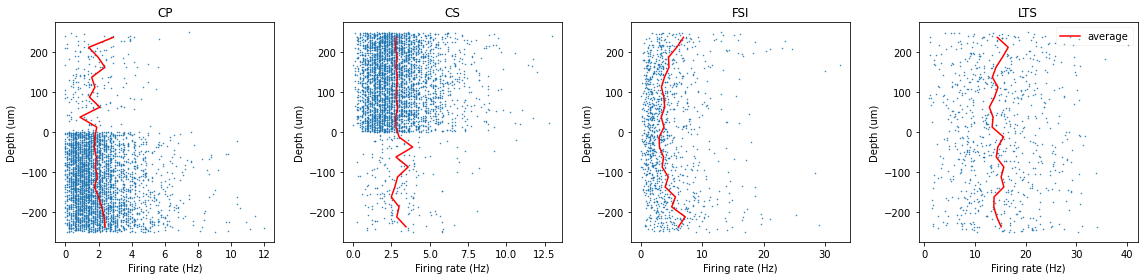

In [6]:
frs = process.firing_rate(spikes_df, num_cells=len(node_df), time_windows=windows)
pop_fr = {p: frs[nid] for p, nid in pop_ids.items()}

if not isbaseline:
    print('Stimulus on time: ')

print('Firing rate: mean, std')
fr_list = []
for p, fr in pop_fr.items():
    fr_list.extend([fr.mean(), fr.std()])
    print(f'{p}: {fr_list[-2]:.3g}, {fr_list[-1]:.3g}')
print('\n'.join(f'{fr:.3g}' for fr in fr_list))

_, axs = plt.subplots(1, len(pop_names), figsize=(4 * len(pop_names), 4))
for ax, p in zip(axs, pop_names):
    fr = pop_fr[p]
    depth = node_df.loc[pop_ids[p], 'pos_z'].values
    fr_mean, depths, _ = sp.stats.binned_statistic(depth, fr, statistic='mean', bins=20)
    ax.plot(fr, depth, '.', markersize=1)
    ax.plot(fr_mean, (depths[1:] + depths[:-1]) / 2, 'r', label='average')
    ax.set_xlabel('Firing rate (Hz)')
    ax.set_ylabel('Depth (um)')
    ax.set_title(p)
ax.legend(loc='upper right', framealpha=0.2)
plt.tight_layout()
plt.show()

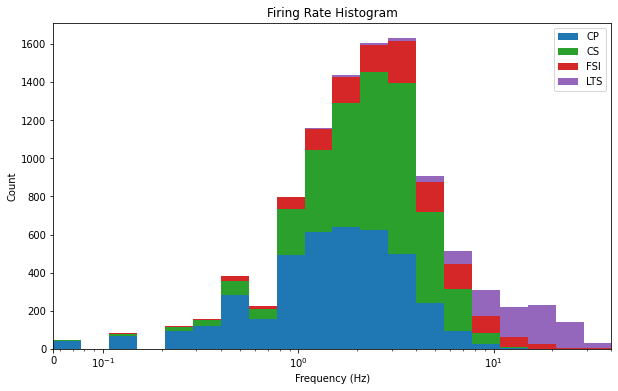

In [7]:
min_fr = 0.5 / process.total_duration(windows)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=True, ax=ax)
plt.show()

### Population spike rate

In [8]:
SAVE_PATH = os.path.join(TRIAL_PATH, 'spike_rate.h5')

if not os.path.isfile(SAVE_PATH) or False:
    fs = 400.
    time = np.array([0, 1000 * t_stop, 1000 / fs])
    pop_rspk = {p: process.pop_spike_rate(spk['timestamps'], time) for p, spk in pop_spike.items()}

    with h5py.File(SAVE_PATH, 'w') as f:
        f.create_dataset('time', data=time)
        grp = f.create_group('populations')
        for p, rspk in pop_rspk.items():
            pop = grp.create_group(p)
            pop.create_dataset('data', data=rspk)
            pop.attrs['number'] = len(pop_ids[p])
else:
    print("File %s already exists. Skip saving." % SAVE_PATH)

File simulation_results\long_div\spike_rate.h5 already exists. Skip saving.


### Calling plot functions directly

In [9]:
# _, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
# pop_spike = plot.plot(choose=1, spike_file=SPIKE_FILE, config=config, figsize=(12, 8))

# if not isbaseline:
#     print('On average: ')
# frs = plot.plot(choose=2, spike_file=SPIKE_FILE, figsize=(10, 6))